Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [114]:
# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install trame
!{sys.executable} -m pip install 'aerosandbox[full]'
!{sys.executable} -m pip install 'gym[all]'

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [165]:
import aerosandbox as asb
import aerosandbox.numpy as np
#HYPERPARAMS
dX_bounds = (-0.1, .1) 
dY_bounds = (-0.1, 0.1)
dZ_bounds = (-0.1, 0.1)
dChord_bounds = (-0.1, 0.1)
dTwist_bounds = (-1, 1)
KT_bounds = (0, 10)
KB_bounds = (0, 3)
N_bounds = (1, 10)
LEW_bounds = (0, 5)

numChords = 2
kulfanWeightResolution = 6

# Lower and upper bounds for each of the parameters
low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
vectorLengthPerXSec = len(low)
# Since you have 9 vectors, the action space will be:
low = np.tile(low, numChords)  # Repeating the pattern 9 times
high = np.tile(high, numChords)

In [166]:
from gym import spaces
import gym
import numpy as np
	
class AeroEnv(gym.Env):
	"""Custom Environment that follows gym interface"""

	def __init__(self):
		super(AeroEnv, self).__init__()

		# Initial values for cross sections
		self.init_xyz_le = [[0, i, 0] for i in range(numChords)]
		self.init_chord = [1] * numChords  														
		self.init_twist = [0] * numChords  														
		self.init_upper_weights = [np.array([0.1] * kulfanWeightResolution,np.float32) for _ in range(numChords)]
		self.init_lower_weights = [np.array([0.1] * kulfanWeightResolution,np.float32) for _ in range(numChords)]
		self.init_leading_edge_weight = [0] * numChords  										
		self.init_N1 = [1] * numChords 															
		self.init_N2 = [1] * numChords

		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(numChords)]

		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)
		

		#Initialize action space
		action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		self.action_space = action_space
		self.observation_space = spaces.Box(low=np.array([-10,-10], np.float32), high=np.array([-10,-10], np.float32), # lift coefficient, drag coefficient
											dtype=np.float32)

	def step(self, action):
		
		for i in range(numChords):
			idx = i * vectorLengthPerXSec
			# Apply dX, dY, dZ

			newXYZ_le = [
					self.xsecs[i].xyz_le[0] + action[idx], 		#x + dx
					self.xsecs[i].xyz_le[1] + action[idx + 1],	#y + dy
					self.xsecs[i].xyz_le[2] + action[idx + 2]	#z + dz
			]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+kulfanWeightResolution + j] for j in range(kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*kulfanWeightResolution]						# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le=newXYZ_le,
				chord=newChord,
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)
		
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)

		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		aero = self.vlm.run()  # Returns a dictionary
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		reward=liftCoeff/dragCoeff
		return [liftCoeff, dragCoeff], reward, reward > 1.4, [liftCoeff, dragCoeff] #last array here is the info object
	
	
	def reset(self):
    # 1. Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(numChords)]

		self.airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,            
					xsecs=self.xsecs
				),
			],
		)

		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		aero = self.vlm.run()
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		
		return [liftCoeff, dragCoeff]
	
	def render(self):
		self.vlm.run()
		self.airplane.draw_three_view()
		self.vlm.draw()
	
	def close (self):
		...

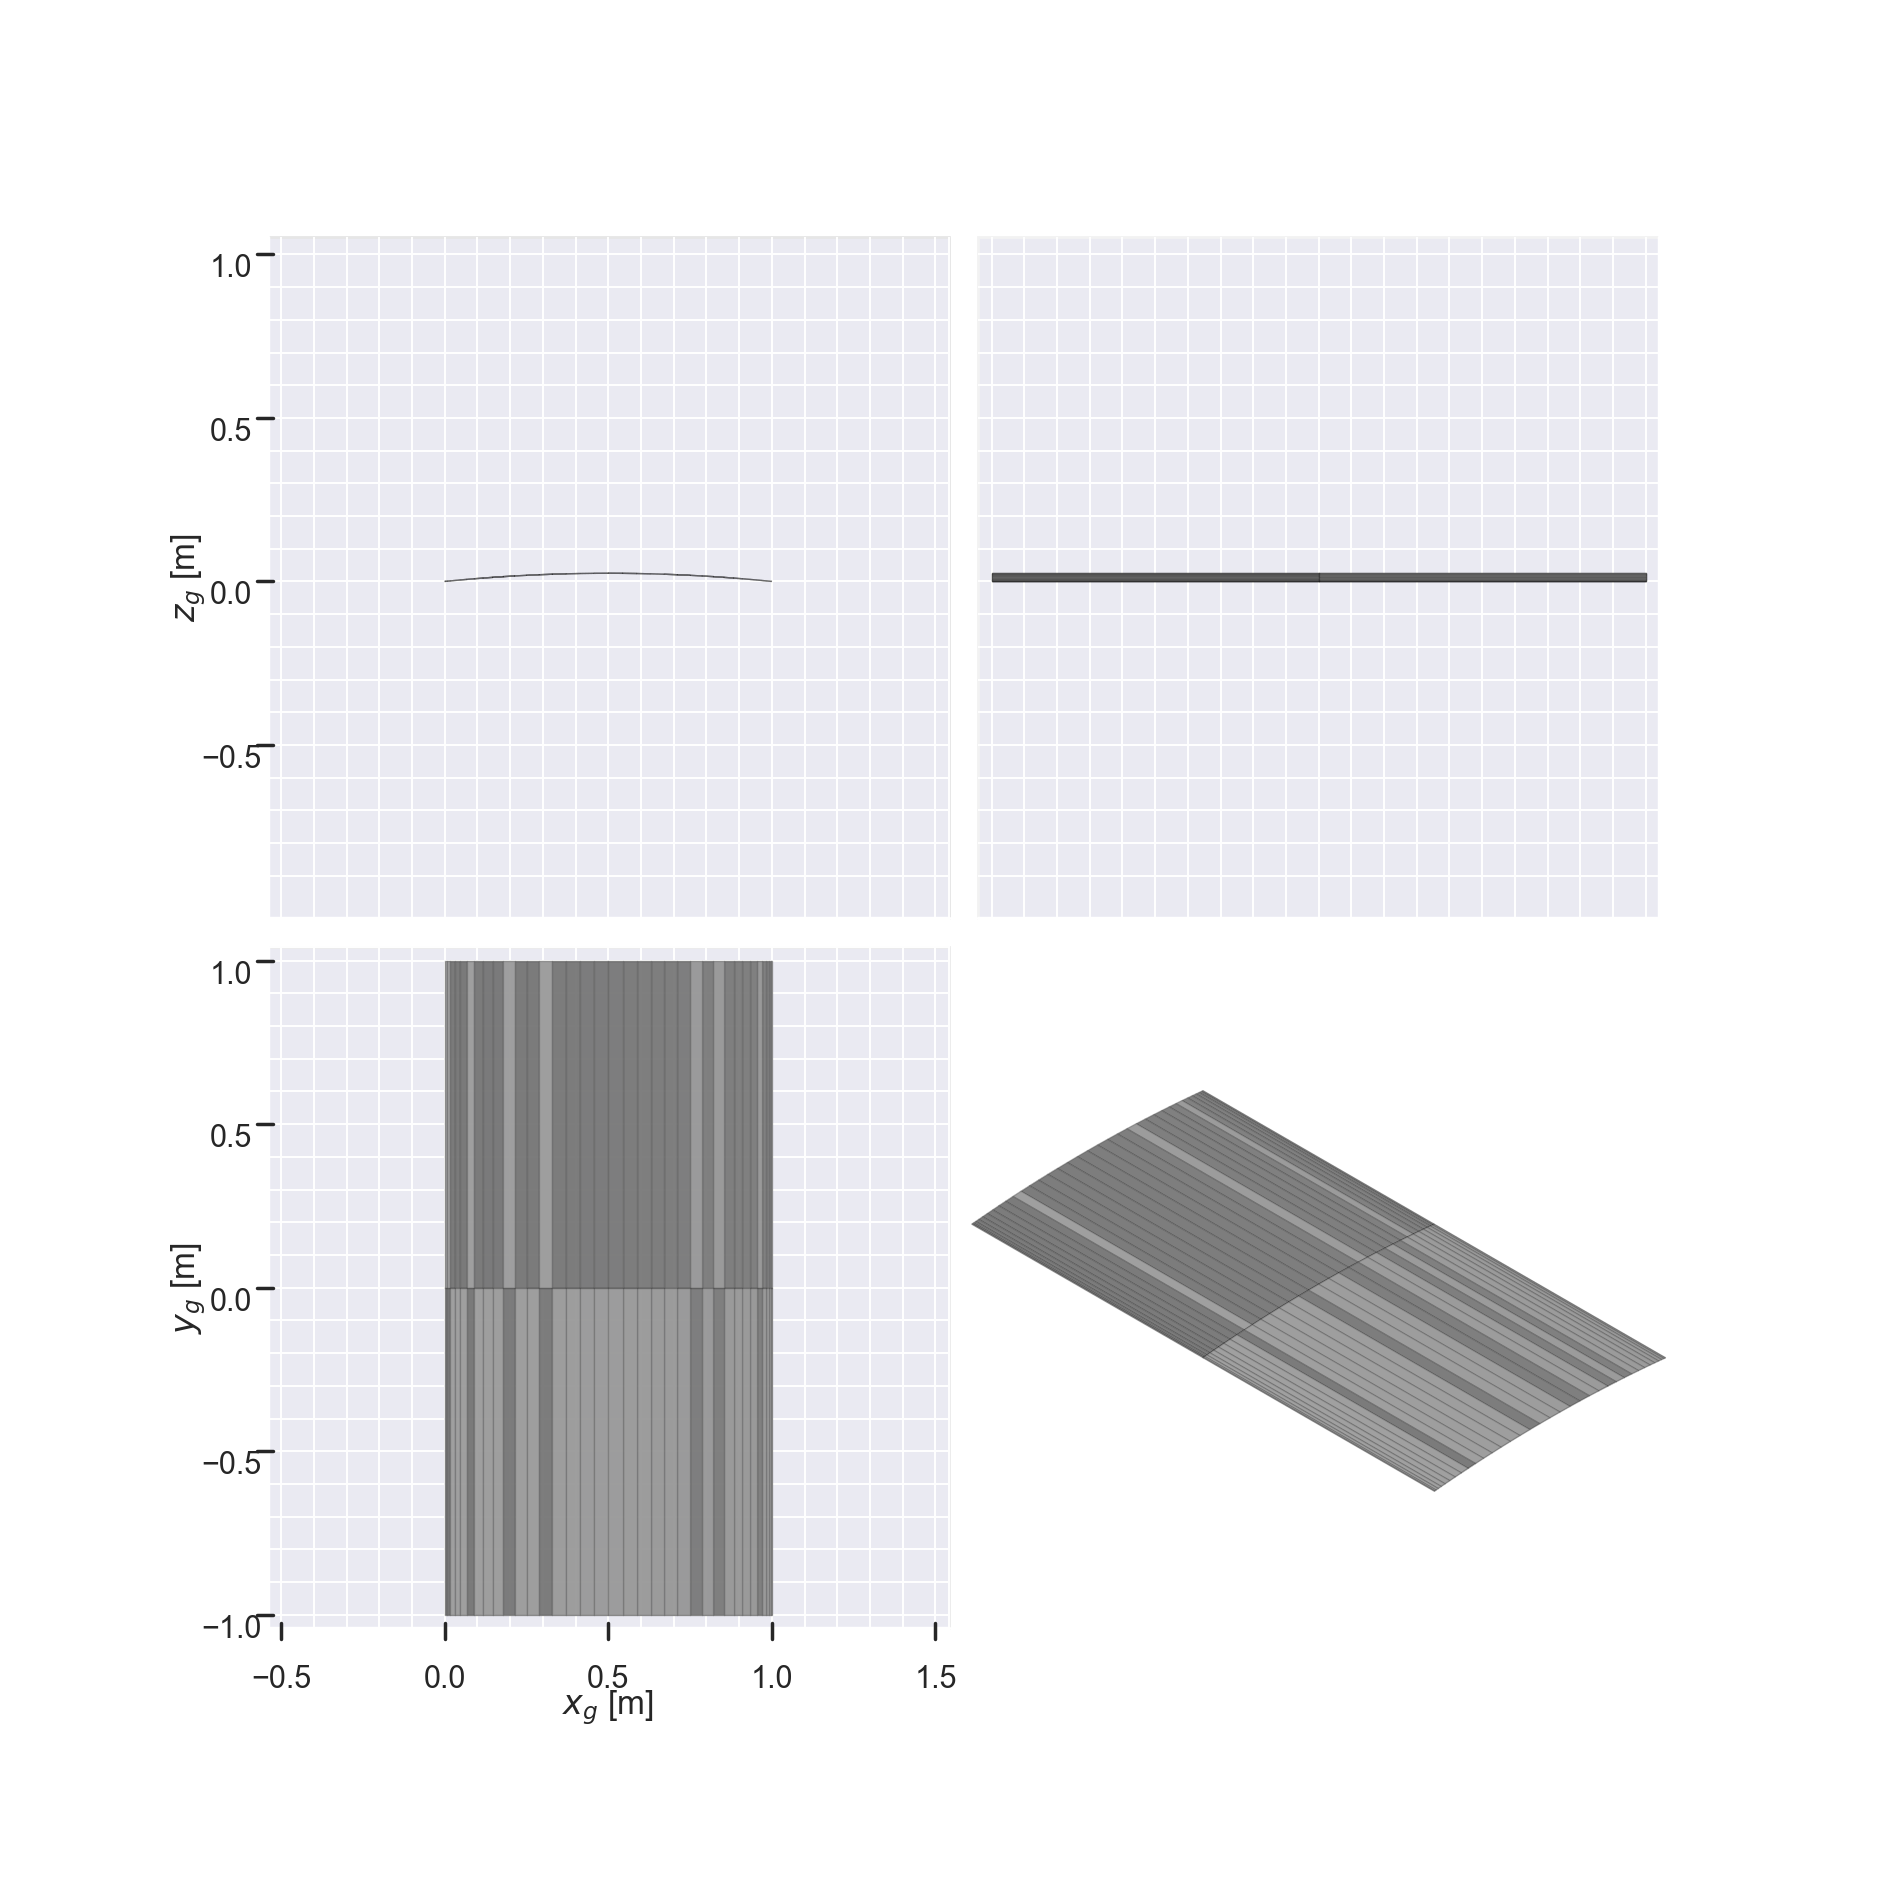

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


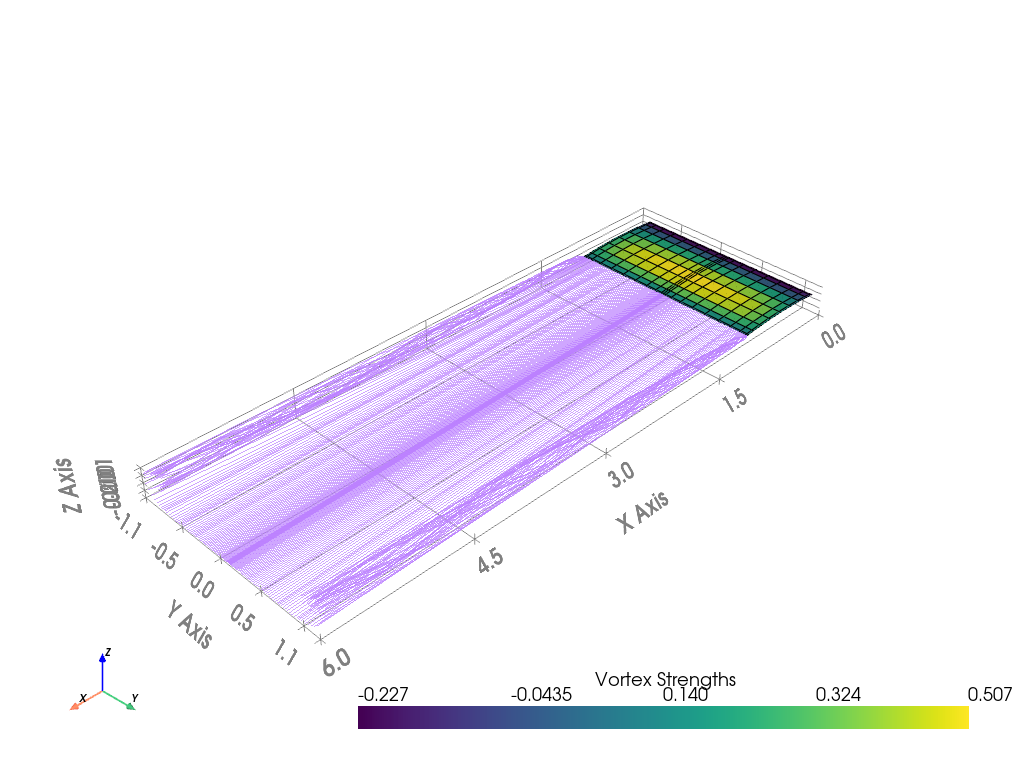

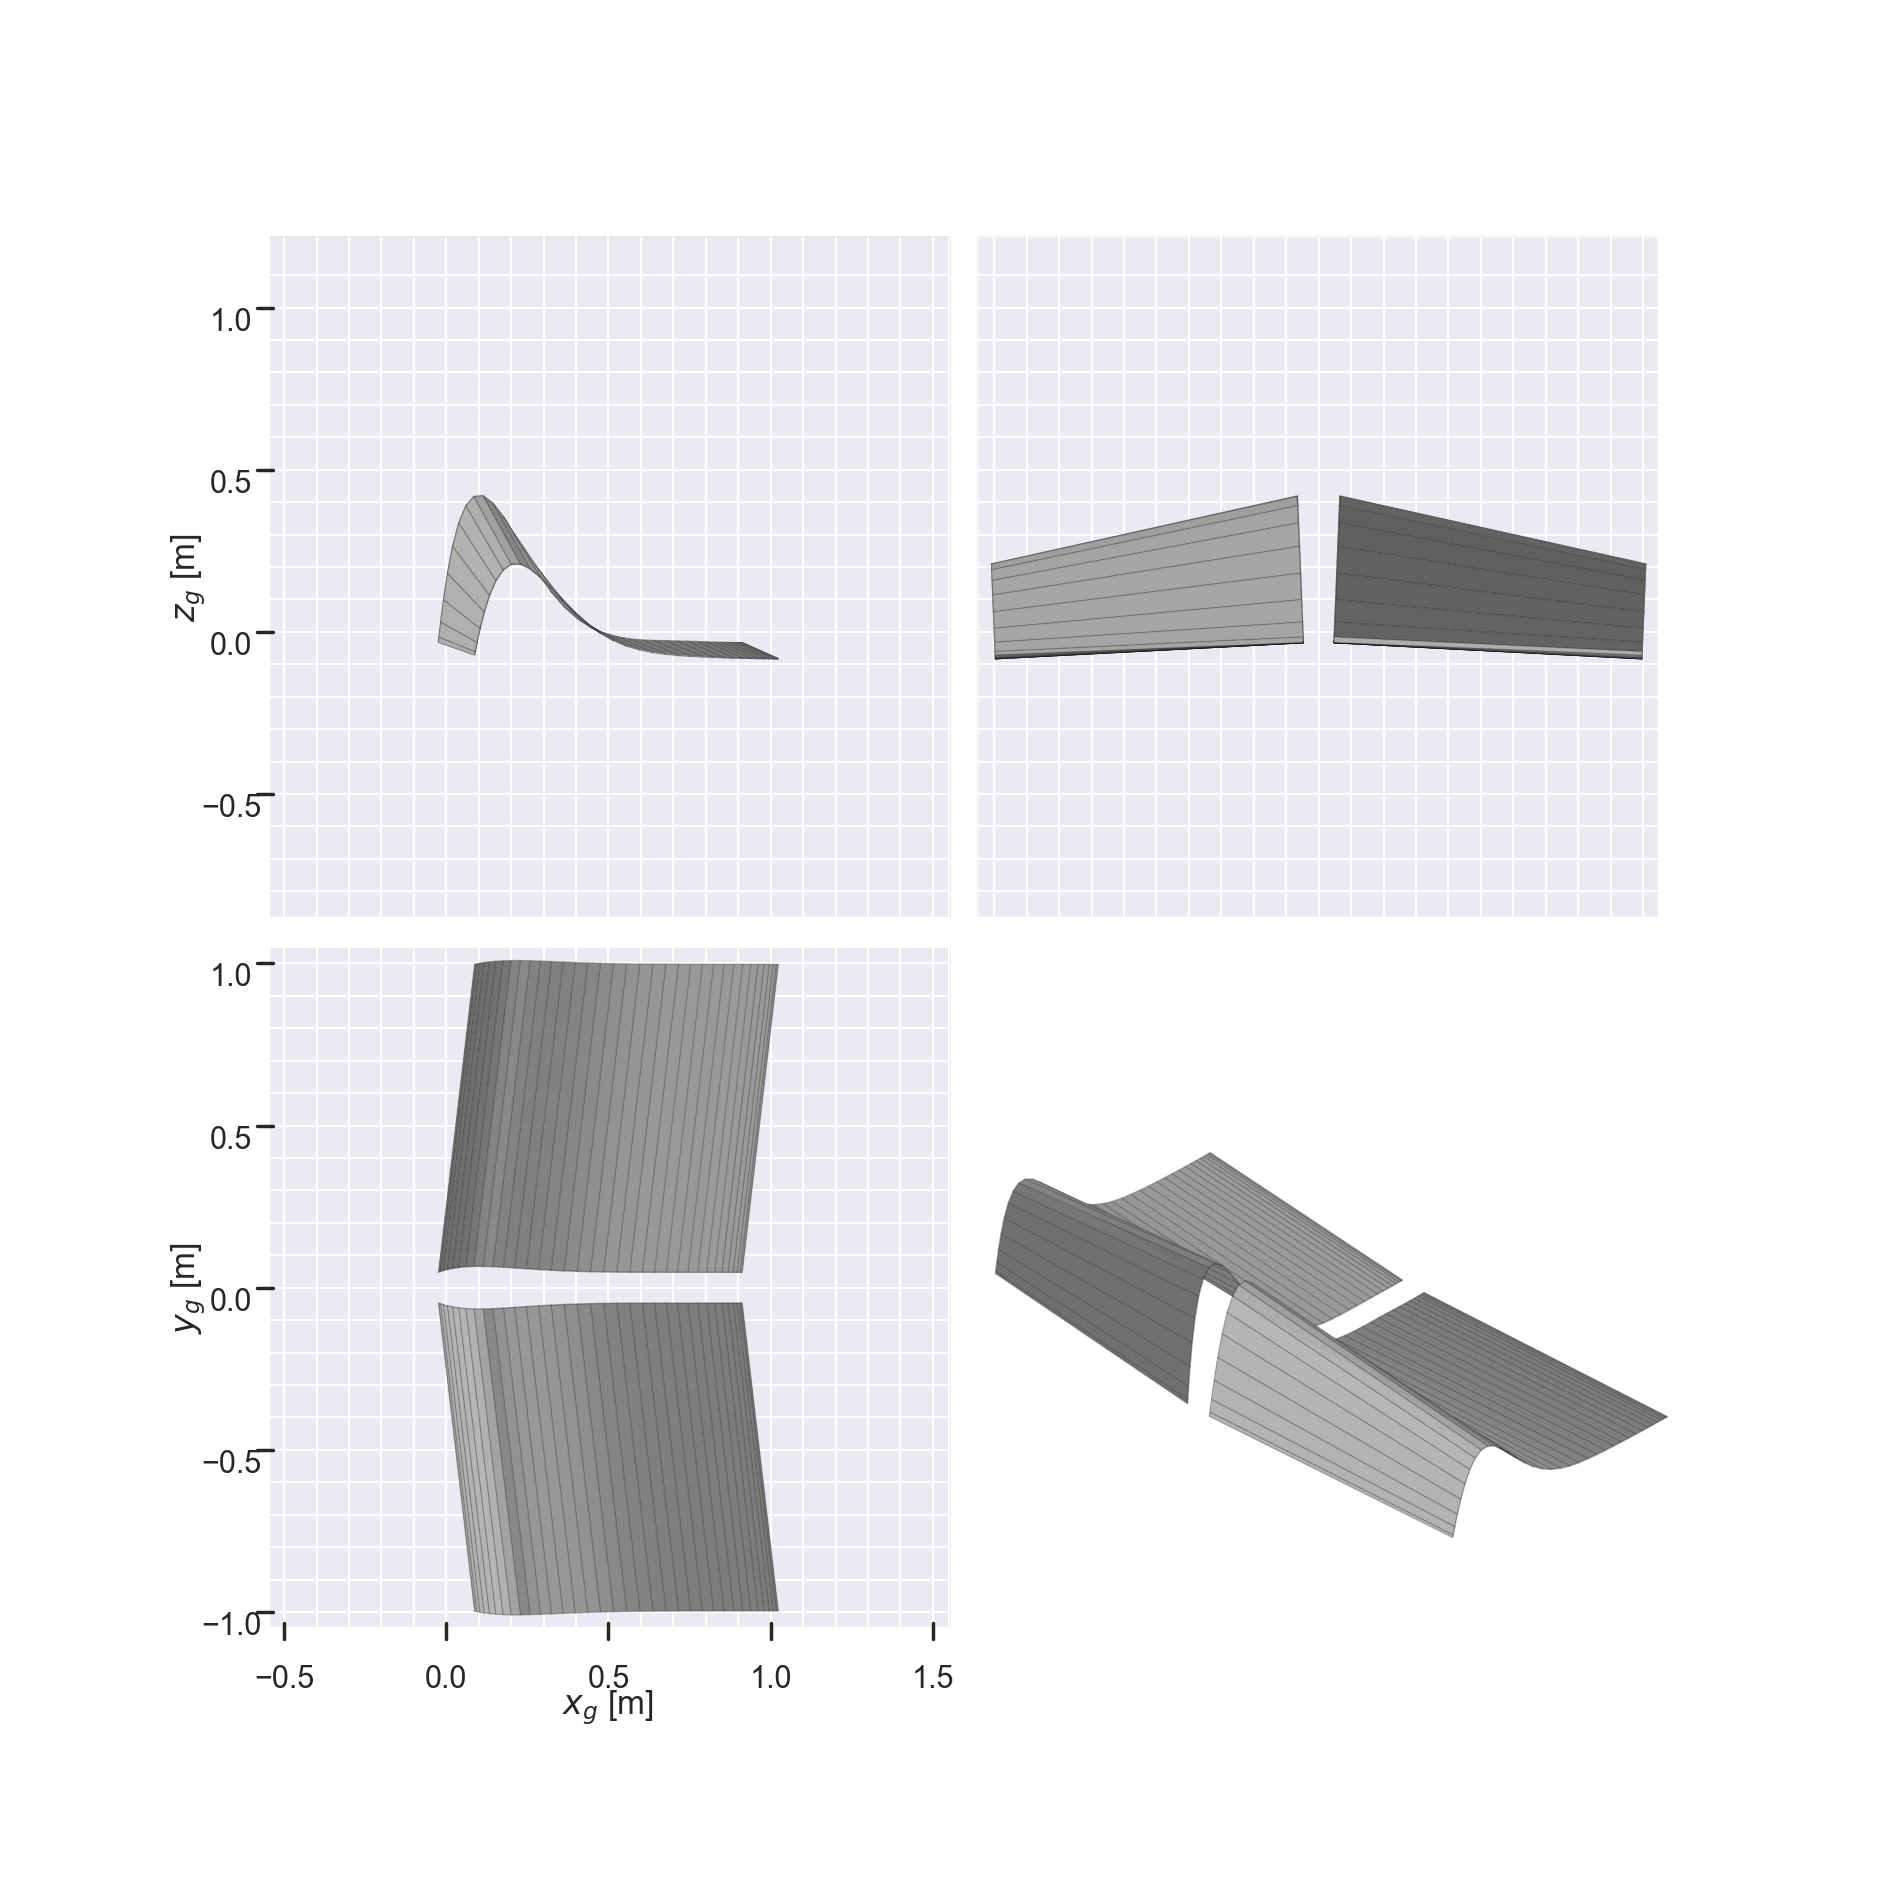

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


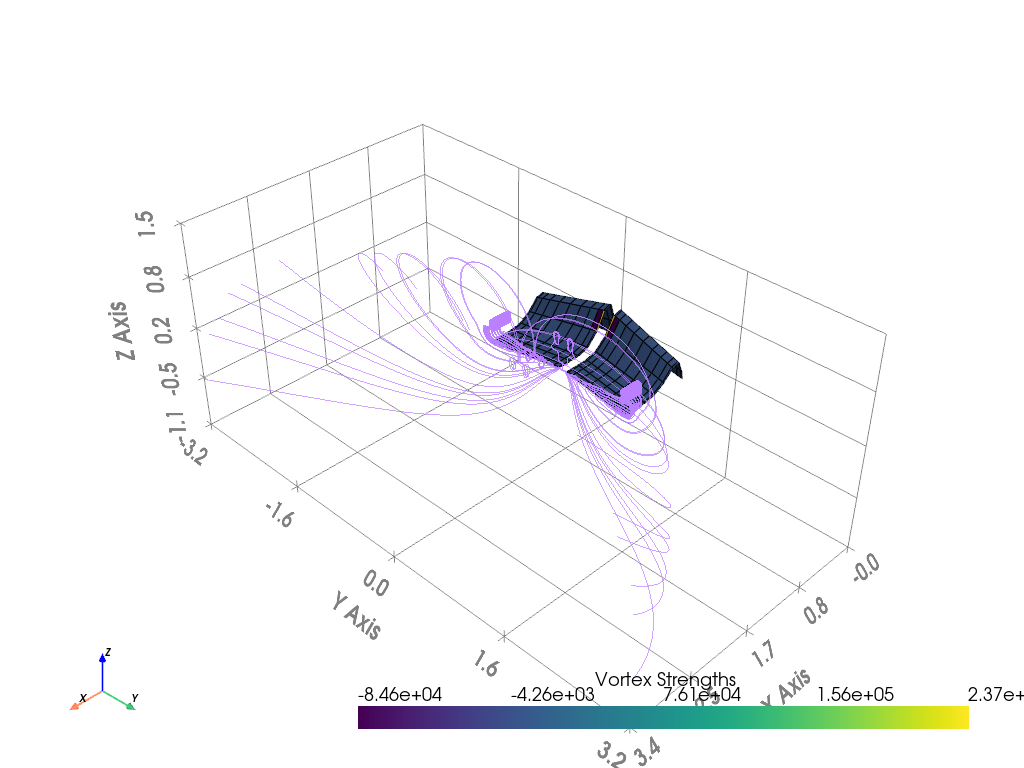

In [167]:
env = AeroEnv()
episodes = 50

obs = env.reset()
random_action = env.action_space.sample()
env.render()
obs, reward, done, info = env.step(random_action)
env.render()

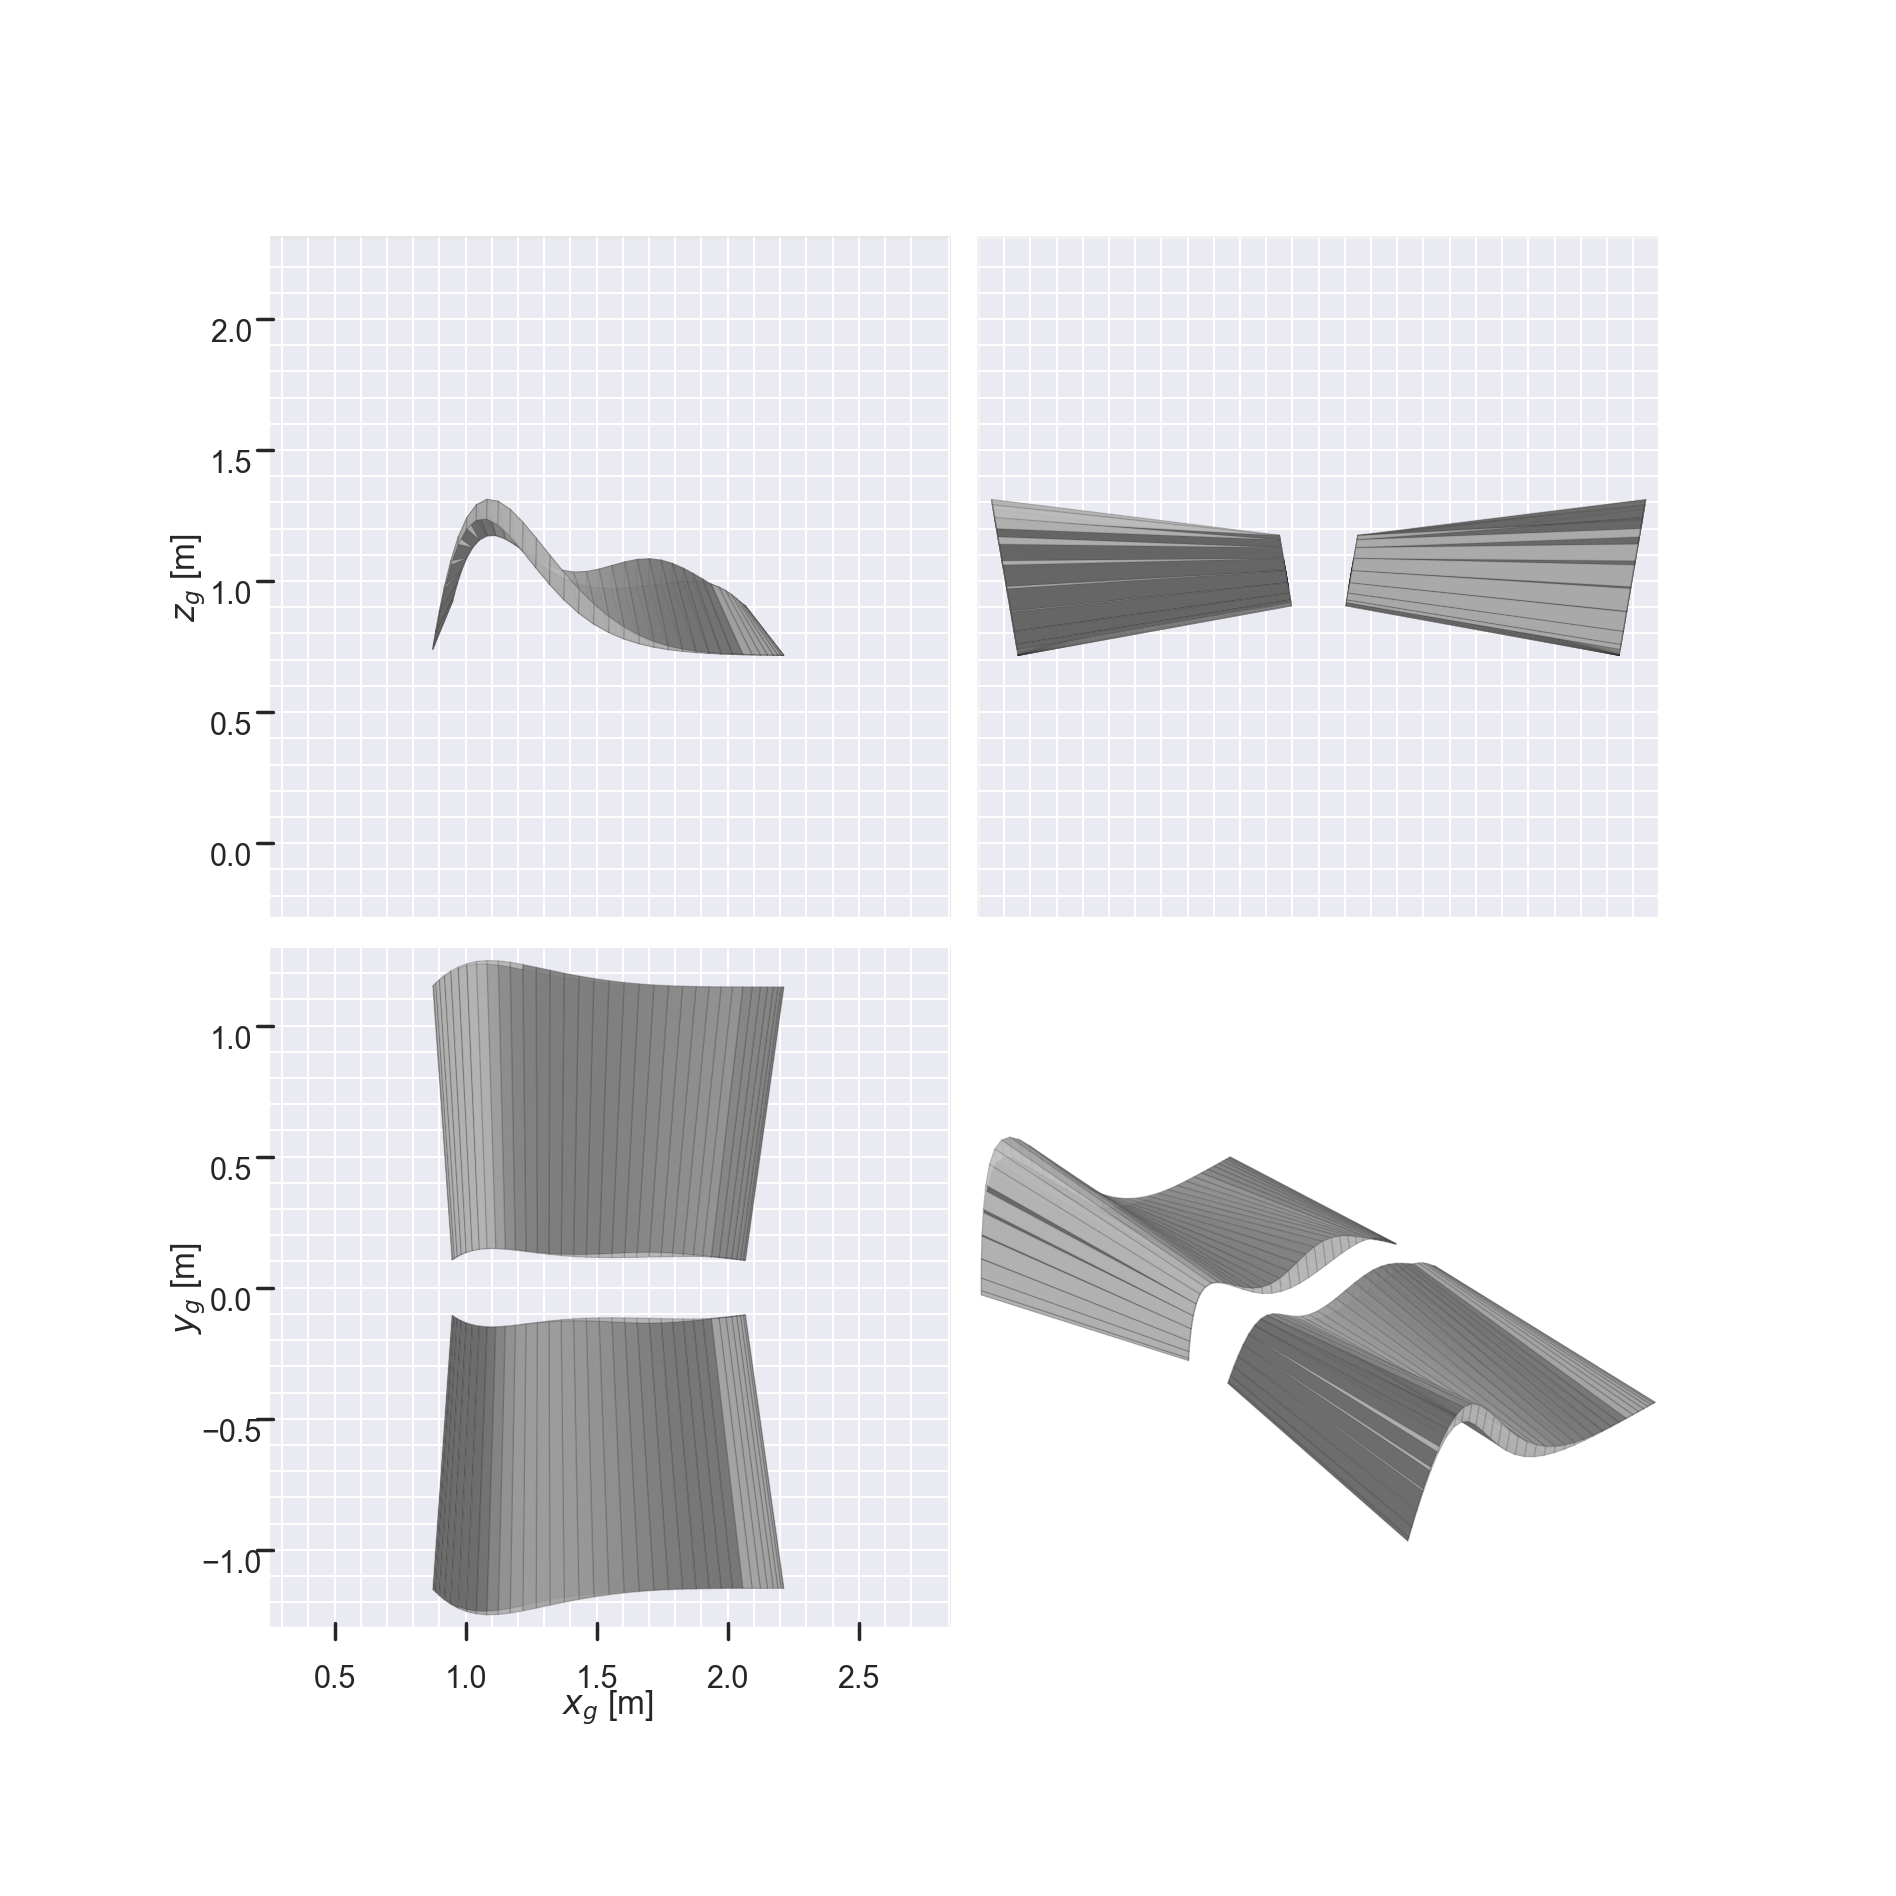

In [146]:
xsec_1 = asb.WingXSec(
    xyz_le=[0.9484702474375929, 0.10604942981249699, 0.9182056164104687],
    chord=1.1187580366580527,
    twist=0.6606838841422351,
    airfoil=asb.KulfanAirfoil(
        upper_weights=np.array([4.52537647, 1.10478106, 8.83825694, 4.96307648, 0.78279428, 1.77910651], dtype=np.float32),
        lower_weights=np.array([2.54250737, 0.29631322, 2.98149482, 0.65123219, 1.33848671, 2.30437112], dtype=np.float32),
        leading_edge_weight=4.463107926890967,
        N1=4.3996640437451315,
        N2=1.2417349745863056
    )
)

xsec_2 = asb.WingXSec(
    xyz_le=[0.8751989727315075, 1.1500387437678548, 0.739664547313719],
    chord=1.3389158419567497,
    twist=0.9914258638717696,
    airfoil=asb.KulfanAirfoil(
        upper_weights=np.array([7.4919331, 3.03598414, 6.244096, 4.63438896, 3.95830195, 1.59355715], dtype=np.float32),
        lower_weights=np.array([0.42023755, 1.03970414, 0.24502565, 2.25653352, 2.19107094, 2.60798026], dtype=np.float32),
        leading_edge_weight=7.097883361303871,
        N1=1.9656564457334222,
        N2=4.266609885624192
    )
)

airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,             # Should this wing be mirrored across the XZ plane?
					xsecs=[xsec_1,xsec_2]
				),
			],
		)

airplane.draw_three_view()




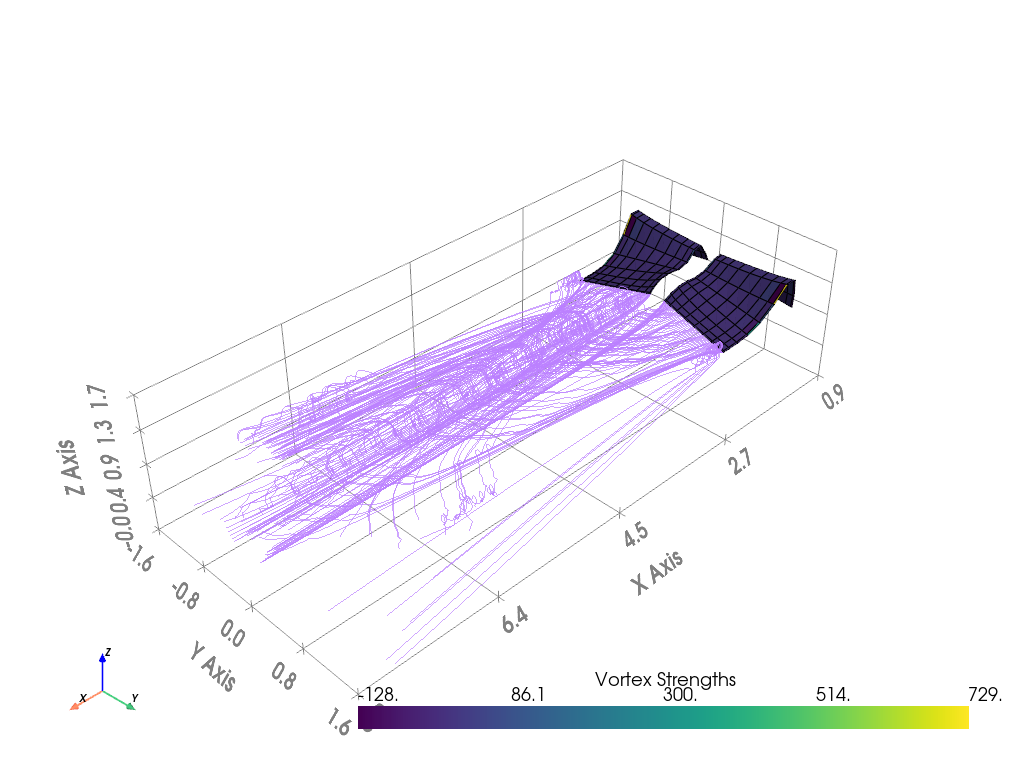

In [147]:
vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=25,  # m/s
        alpha=5,  # degree
    )
)
aero = vlm.run()  # Returns a dictionary
vlm.draw(show_kwargs=dict(jupyter_backend="static"))